# Retreive data

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
from scipy.signal import find_peaks

#shot 966, 962

shot_no = 966

#path of plasma current
path_current = os.getcwd() + r"\resources\magneticSignal\Plasma current for plasma position.xlsx"
path_signal = os.getcwd() + r"\resources\magneticSignal\Magnetic probe GBP_T for plasma position.xlsx"

df_current = pd.read_excel(path_current, sheet_name = "Sheet1")
df_signal = pd.read_excel(path_signal, sheet_name = f"shot_{shot_no}")

#flip signal of all coils to be positive (probe installation error)
min_len = df_signal.dropna().shape[0]
df_signal = df_signal.iloc[:min_len] #one of the column size is longer

recorded_time = df_current.loc[:, "Time [ms]"]
recorded_current = df_current.loc[:,shot_no]

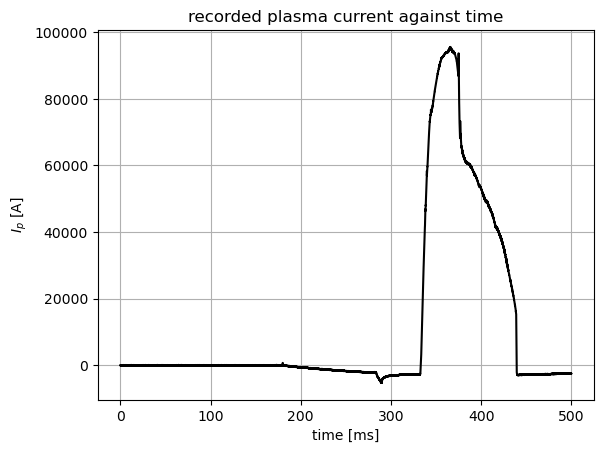

In [3]:
plt.plot(recorded_time,recorded_current, color = "black")
plt.title("recorded plasma current against time")
plt.xlabel("time [ms]")
plt.ylabel("$I_p$ [A]")
plt.grid()

In [4]:
def discharge_duration(time, plasma_current) -> float:
    """
    calculate discharge time from plasma current

    :param time: array of recorded time
    :param plasma_current: array of recorded plasma current
    :return: discharge time
    """
    inverted_signal = -plasma_current
    peaks, _ = find_peaks(inverted_signal,height=4000,distance = 150)

    current = plasma_current[peaks[0]]
    count = 0

    #find time for start of plasma discharge
    while current <= 0: #current equal to 0 will cause zero division
        count += 1
        current = plasma_current[peaks[0] + count]

    discharge_begin = time[peaks[0] + count]

    #find time for end of plasma discharge
    while current > 0:
        count += 1
        current = plasma_current[peaks[0] + count]
    
    discharge_end = time[peaks[0] + count]

    return (discharge_begin, discharge_end)

In [9]:
begin, end = discharge_duration(recorded_time,recorded_current)

#extract data from plasma
time = recorded_time[(recorded_time > begin) & (recorded_time < end)]
plasma_current = recorded_current[(recorded_time > begin) & (recorded_time < end)]

plasma_signal = df_signal[(df_signal["Time (ms)"] > begin) & (df_signal["Time (ms)"] < end)]
plasma_signal = plasma_signal - plasma_signal.iloc[0]
plasma_signal.iloc[:,1:10] *= -1
plasma_signal.iloc[:,12] *= -1

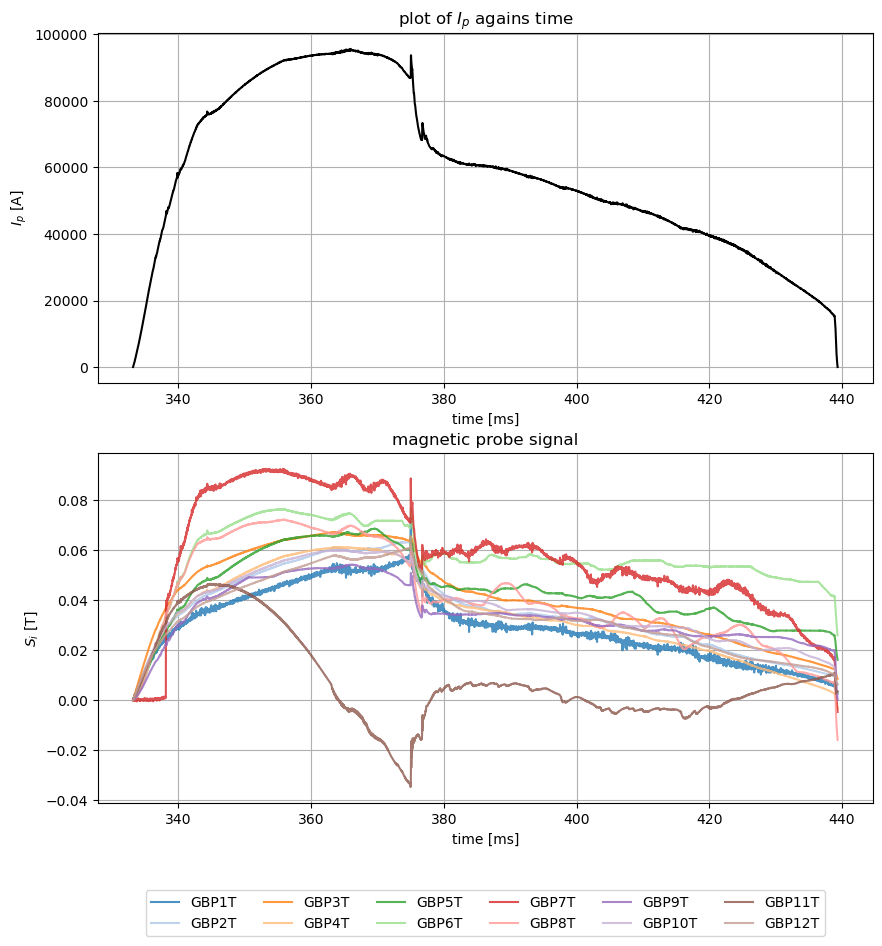

In [10]:
column_names = plasma_signal.columns[1:]


fig, (ax0,ax2) = plt.subplots(2,1, figsize = (10,10))
ax0.plot(time, plasma_current,color = "black")
ax0.set_xlabel("time [ms]")
ax0.set_ylabel("$I_p$ [A]")
ax0.grid()
ax0.set_title("plot of $I_p$ agains time")

cmap = plt.get_cmap("tab20")  # A colormap with 10 distinct colors

# for i,name in enumerate(column_names):
#     ax1.plot(recorded_time, df_signal[name], label = name, color = cmap(i),alpha = 0.8)
# ax1.axvline(begin, color = "black")
# ax1.set_xlabel("time [ms]")
# ax1.set_ylabel("$S_i$ [T]")
# ax1.grid()
# ax1.set_title("raw magnetic probe signal")
# ax1.legend()

for i, name in enumerate(column_names):
    ax2.plot(time, plasma_signal[name], label=name, color=cmap(i),alpha = 0.8)
ax2.set_xlabel("time [ms]")
ax2.set_ylabel("$S_i$ [T]")
ax2.grid()
ax2.set_title("magnetic probe signal")
ax2.legend(loc = "lower center", bbox_to_anchor = (0.5,-0.4), ncol = 6)

In [11]:
from tqdm import tqdm
from toroidalFilament.plasma_shift import cal_shift
from toroidalFilament.DxDz import cal_newton_DxDz as newton
from toroidalFilament.geometry_TT1 import cross, cross_perfect
from toroidalFilament import signal_strength
R0_nomi,Z0_nomi = [0.00], [0.00]
R0_err,Z0_err = [0.00], [0.00]

R1_nomi,Z1_nomi = [0.00], [0.00]
R1_err,Z1_err = [0.00], [0.00]

R2_nomi, Z2_nomi = [0.00], [0.00]
R2_err,Z2_err = [0.00], [0.00]

def experimental_shift(signal,R_arr,R_err,Z_arr,Z_err,cross,taylor_order = 2):
    shift = cal_shift(DxDz_method=newton, taylor_order = taylor_order, signal=signal, est_horizontal_shift=R_arr[-1]
                      ,est_vertical_shift=Z_arr[-1],coil_angle= cross,
                      alpha_vertical_range=np.linspace(-0.05,0.05,101), beta_horizontal_range=np.linspace(-0.05,0.05,101))
    
    R_arr.append(shift[0,0])
    R_err.append(shift[0,1])

    Z_arr.append(shift[1,0])
    Z_err.append(shift[1,1])

    return

index = 0

time_constrained_signal = plasma_signal.iloc[1:][time.iloc[1:] < 370]  # Ensure alignment
for index, signal in enumerate(tqdm(time_constrained_signal.to_numpy())):
    signal_strength.I = plasma_current.to_numpy()[index]

    signal0 = np.array([signal[12],signal[2],signal[6],signal[8]])
    signal1 = np.array([signal[12], signal[3],signal[6],signal[9]])
    # signal2 = np.array([signal[2], signal[5],signal[8],signal[11]])

    experimental_shift(signal0, R0_nomi,R0_err,Z0_nomi,Z0_err,cross = [cross[0][0], cross[2][0], cross[0][2], cross[2][2]])
    experimental_shift(signal1, R1_nomi,R1_err,Z1_nomi,Z1_err,cross= cross[0])
    # experimental_shift(signal2,R2_nomi,R2_err,Z2_nomi,Z2_err,cross=cross[2])
    
    index += 1

100%|██████████| 1840/1840 [01:05<00:00, 28.09it/s]


<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_77008\2623145507.py:16: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta_{||} [m]$")


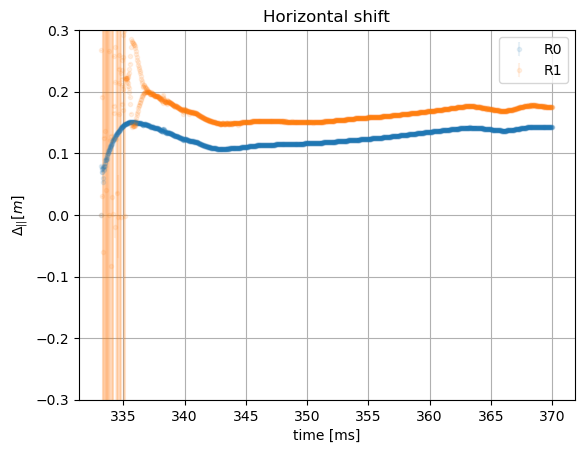

In [13]:
time_plot = time.to_numpy()

def plot_shift(nomi,err,name):
    # factor = 0.15 if name == "R0" else 0.1
    factor = 0
    plt.errorbar(time[:len(nomi)], np.array(nomi) - factor,yerr = err,fmt = ".",capsize=0.1, capthick=0.5,alpha = 0.1, label = name)

plot_shift(np.array(R0_nomi),R0_err, "R0")
plot_shift(np.array(R1_nomi),R1_err,"R1")
# plot_shift(np.array(R2_nomi),R2_err,"R2")

plt.title("Horizontal shift")
plt.ylim(-0.3,0.3)
plt.grid()
plt.xlabel("time [ms]")
plt.ylabel("$\Delta_{||} [m]$")
plt.legend()

<>:9: SyntaxWarning: invalid escape sequence '\D'
<>:9: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_77008\7726465.py:9: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta_\perp$")


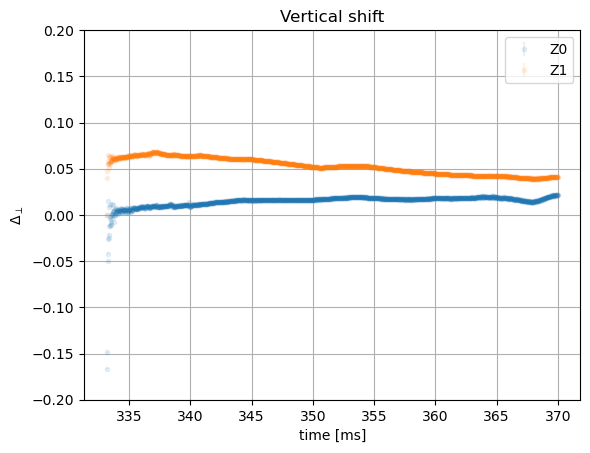

In [14]:
plot_shift(np.array(Z0_nomi),Z0_err, "Z0")
plot_shift(Z1_nomi,Z1_err, "Z1")
# plot_shift(Z2_nomi,Z2_err,"Z2")

plt.title("Vertical shift")
plt.grid()
plt.ylim(-0.2,0.2)
plt.xlabel("time [ms]")
plt.ylabel("$\Delta_\perp$")
plt.legend()

# Caluculate mean R

In [9]:
#find distance of center to coil

def find_R(loc1,loc2):
    return np.sqrt((loc1[0]- loc2[0])**2 + (loc1[1]-loc2[1])**2) / 2 / 1000

loc_lst = [(973.9,-14.5),(936.1,147.8),(822.3,269.1),(663.1,317.3),(501.2,279.4),(379.9,165.7),
           (331.7,6.487),(369.5,-155.5),(483.3,-276.8),(642.5,-325),(807.6,-285.4),(925.8,-173.3)]

R_lst = [find_R(loc_lst[i], loc_lst[i+6]) for i in range(0,len(loc_lst)//2)]
print(R_lst)
print(np.mean(R_lst), np.std(R_lst))

[0.32127141725066366, 0.32133566951087145, 0.3212972961293014, 0.3213151295846493, 0.32127869521647395, 0.3212972961293014]
0.32129925063687687 2.1538099038494595e-05


# simulate signal

In [27]:
import signal_strength
from geometry_TT1 import cross
from signal_strength import cal_signal

all_signal = np.zeros((0,4))
all_time = df_current["Time [ms]"].to_numpy()

for I in df_current[966].to_numpy():
    signal_strength.I = I
    signal = cal_signal(0.65,0,coil_angle=[cross[0][0], cross[2][0], cross[0][2], cross[2][2]])
    all_signal = np.vstack((all_signal, signal))

(0.0, 0.0075)

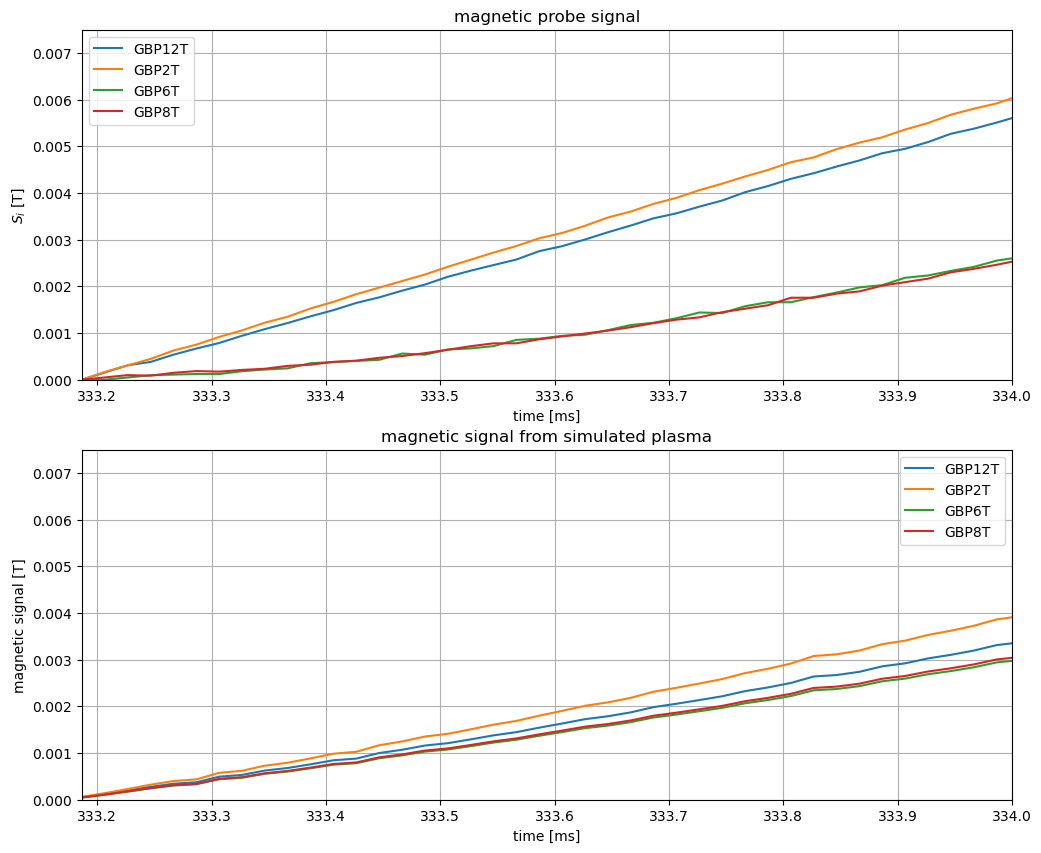

In [29]:
column_names = plasma_signal.columns[1:]

fig, (ax1,ax2) = plt.subplots(2, figsize = (12,10))

ax1.plot(time, plasma_signal["GBP12T"], label="GBP12T")
ax1.plot(time, plasma_signal["GBP2T"], label="GBP2T")
ax1.plot(time, plasma_signal["GBP6T"], label="GBP6T")
ax1.plot(time, plasma_signal["GBP8T"], label="GBP8T")

ax1.set_xlabel("time [ms]")
ax1.set_ylabel("$S_i$ [T]")
ax1.grid()
ax1.set_title("magnetic probe signal")
ax1.legend()
ax1.set_xlim(333.186673,334)
ax1.set_ylim(0,0.0075)

ax2.plot(all_time, all_signal, label = ["GBP12T", "GBP2T","GBP6T","GBP8T"])
ax2.set_xlabel("time [ms]")
ax2.set_ylabel("magnetic signal [T]")
ax2.grid()
ax2.legend()
ax2.set_title("magnetic signal from simulated plasma")
ax2.set_xlim(333.186673,334)
ax2.set_ylim(0,0.0075)